In [1]:
%pylab inline
%config InlineBackend.figure_format = 'retina'

Populating the interactive namespace from numpy and matplotlib


In [2]:
import astropy.cosmology as cosmo
from astropy.cosmology import Planck15
import astropy.units as u
import bz2
import corner
import h5py
import pickle
import pystan
from scipy.stats import gaussian_kde
import seaborn as sns

sns.set_context('notebook')
sns.set_style('ticks')
sns.set_palette('colorblind')

First, load the data:

In [8]:
nsamp = 64
chain = {}
with h5py.File('observations.h5', 'r') as f:
    for n in ['m1det', 'm2det', 'dl']:
        chain[n] = array(f['posteriors'][n])
        
    nn, Tobs = f.attrs['1yr']
    nn = int(round(nn))
    
    for k in chain.keys():
        chain[k] = chain[k][:nn,:]

#     Tobs = f.attrs['Tobs']

In [5]:
with h5py.File('selected.h5', 'r') as inp:
    N_gen = inp.attrs['N_gen']

    m1s_det = array(inp['m1det'])
    m2s_det = array(inp['m2det'])
    dls_det = array(inp['dl'])
    wts_det = array(inp['wt'])

In [6]:
nsel = 65536
f = nsel / len(m1s_det)
N_gen = int(round(N_gen*f))
m1s_det = m1s_det[:nsel]
m2s_det = m2s_det[:nsel]
dls_det = dls_det[:nsel]
wts_det = wts_det[:nsel]

In [7]:
ndet = m1s_det.shape[0]
nobs = chain['m1det'].shape[0]

In [9]:
m1 = []
m2 = []
dl = []

for i in range(nobs):
    s = np.random.choice(chain['m1det'].shape[1], nsamp, replace=False)
    m1.append(chain['m1det'][i,s])
    m2.append(chain['m2det'][i,s])
    dl.append(chain['dl'][i,s])

In [10]:
ninterp = 500
zMax = 10
zinterp = expm1(linspace(log(1), log(zMax+1), ninterp))

In [11]:
m = pystan.StanModel(file='model.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d3607629e6fff1fd0dc8797c207d1c37 NOW.
/Users/wfarr/anaconda3/lib/python3.6/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /var/folders/35/vcq24mtj2_g5wk96mbck0cw400018s/T/tmp2obb5l86/stanfit4anon_model_d3607629e6fff1fd0dc8797c207d1c37_6026370221266578432.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


In [15]:
d = {
    'nobs': nobs,
    'nsel': ndet,
    'ninterp': ninterp,
    'nsamp': nsamp,

    'Tobs': Tobs,
    'N_gen': N_gen,

    'm1obs': m1,
    'm2obs': m2,
    'dlobs': dl,

    'm1sel': m1s_det,
    'm2sel': m2s_det,
    'dlsel': dls_det,
    'log_wtsel': log(wts_det),

    'zinterp': zinterp,

    'cosmo_prior': 1
}

In [16]:
r = m.vb(data=d, algorithm='fullrank')

In [17]:
class vb_result_wrapper(object):
    def __init__(self, r):
        self._r = r
    @property
    def r(self):
        return self._r
    
    def __getitem__(self, k):
        try:
            i = r['sampler_param_names'].index(k)
            return array(r['sampler_params'][i])
        except:
            rs = []
            j = 1
            while '{:s}[{:d}]'.format(k, j) in r['sampler_param_names']:
                rs.append(r['sampler_params'][r['sampler_param_names'].index('{:s}[{:d}]'.format(k, j))])
                j += 1
            if j > 1:
                return column_stack(rs)
            else:
                raise KeyError('Key not found: {:s}'.format(k))

In [18]:
w = vb_result_wrapper(r)

Safety factor (1% of Neff / 4*Nobs) = 2.3


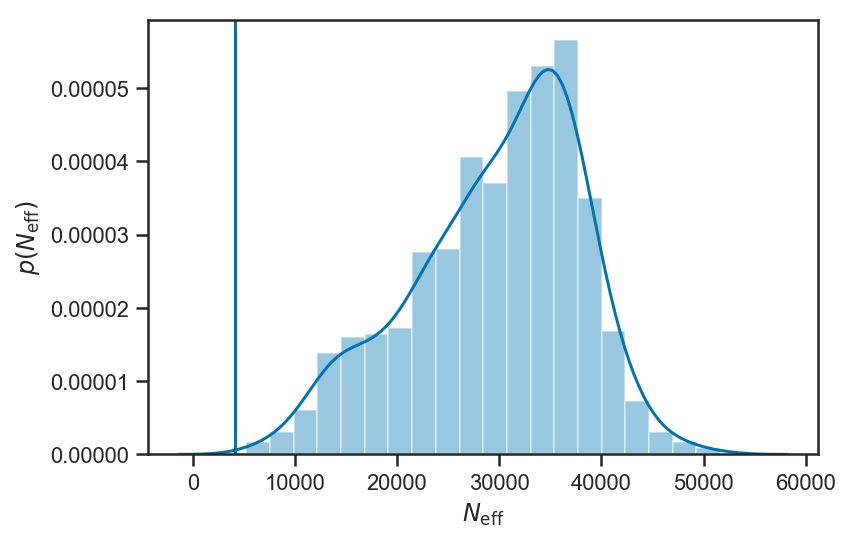

In [19]:
sns.distplot(w['neff_det'])
axvline(4*d['nobs'])
xlabel(r'$N_\mathrm{eff}$')
ylabel(r'$p\left( N_\mathrm{eff}\right)$')

print('Safety factor (1% of Neff / 4*Nobs) = {:.1f}'.format(percentile(w['neff_det'], 1)/(4*d['nobs'])))

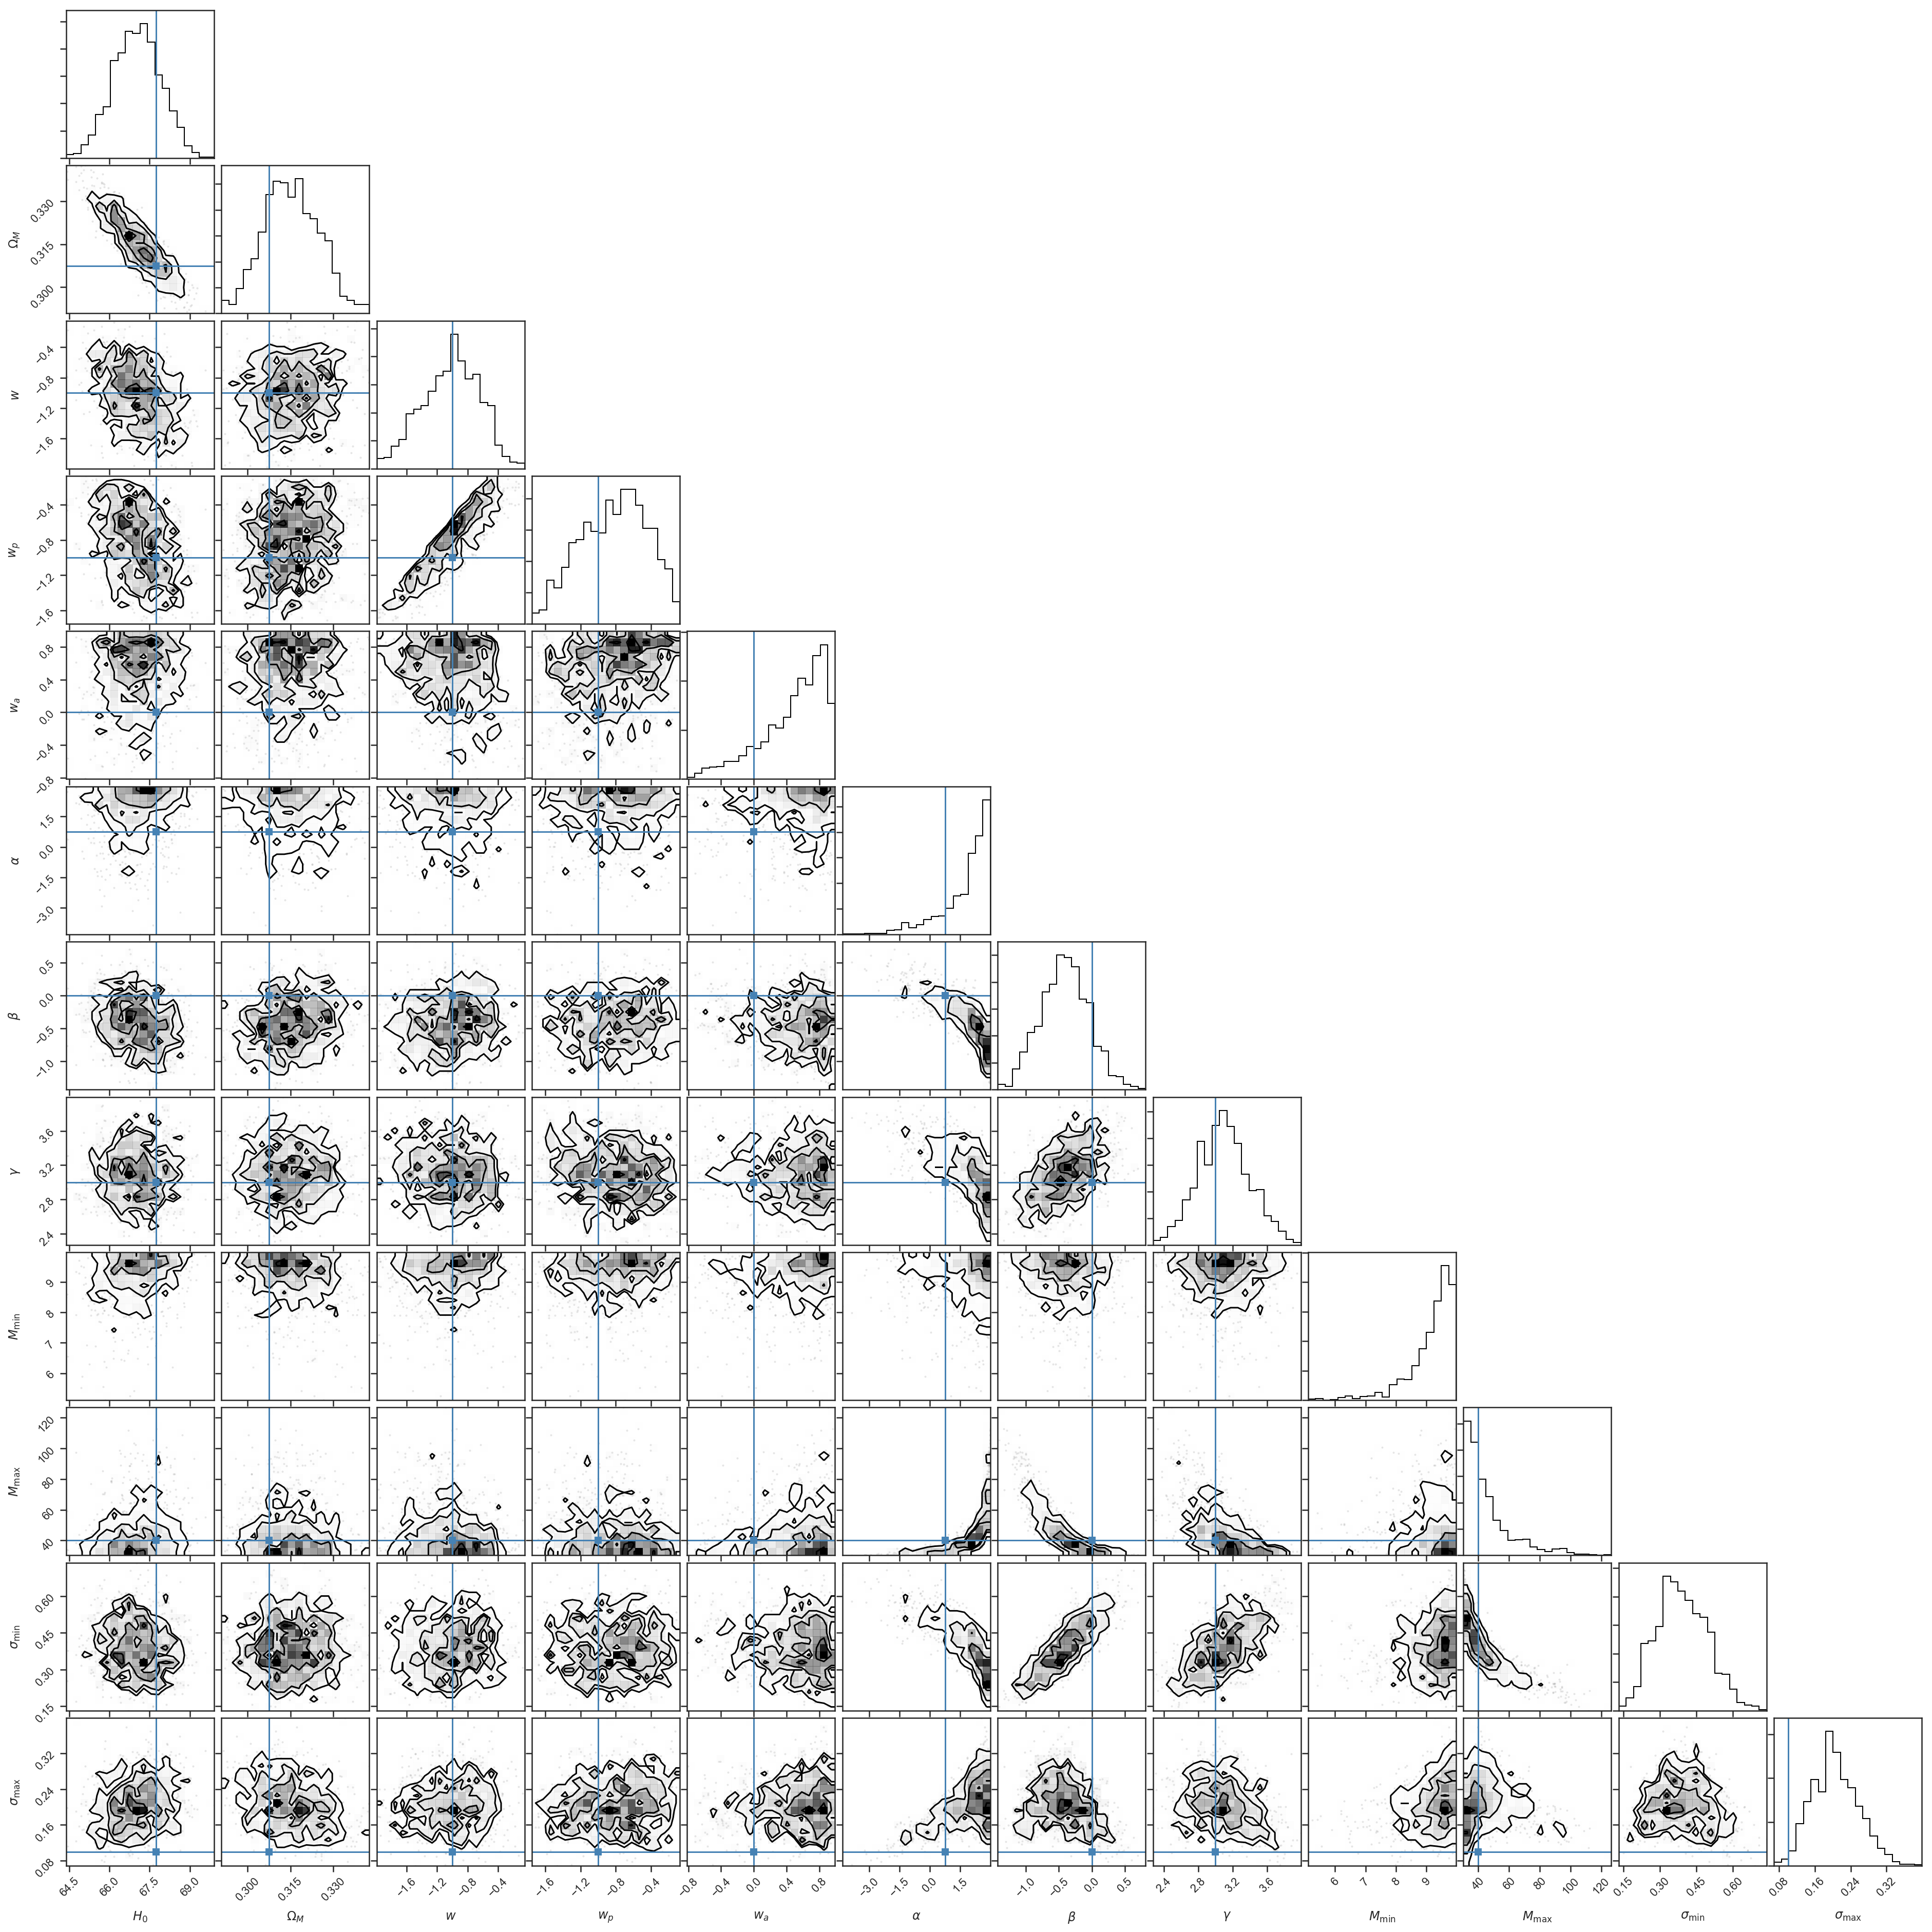

In [24]:
corner.corner(column_stack([w[k] for k in ['H0', 'Om', 'w', 'w_p', 'w_a', 'alpha', 'beta', 'gamma', 'MMin', 'MMax', 'sigma_min', 'sigma_max']]),
              labels=[r'$H_0$', r'$\Omega_M$', r'$w$', r'$w_p$', r'$w_a$', r'$\alpha$', r'$\beta$', r'$\gamma$', r'$M_\mathrm{min}$', r'$M_\mathrm{max}$', r'$\sigma_\mathrm{min}$', r'$\sigma_\mathrm{max}$'],
              truths=[Planck15.H0.to(u.km/u.s/u.Mpc).value, Planck15.Om0, -1.0, -1.0, 0.0, 0.75, 0.0, 3.0, 5.0, 40.0, 0.1, 0.1]);

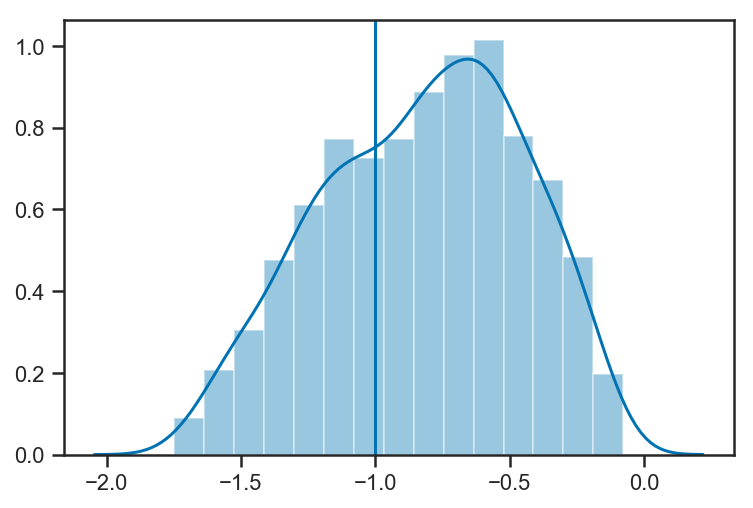

In [25]:
sns.distplot(w['w_p'])
axvline(-1)

In [26]:
print('w = {:.2f} +/- {:.2f}'.format(mean(w['w_p']), std(w['w_p'])))

w = -0.82 +/- 0.37


In [27]:
p = m.optimizing(data=d)

In [28]:
p

OrderedDict([('H0', array(67.74850629)),
             ('Omh2', array(0.14206225)),
             ('w_p', array(-0.82943238)),
             ('w_a', array(-0.02402407)),
             ('MMin', array(3.00020507)),
             ('MMax', array(39.04814927)),
             ('MLow2Sigma', array(1.00000009)),
             ('MHigh2Sigma', array(47.66651101)),
             ('alpha', array(0.61247822)),
             ('beta', array(-0.11892973)),
             ('gamma', array(3.20419042)),
             ('sigma_min', array(0.54934028)),
             ('sigma_max', array(0.0997168)),
             ('w', array(-0.81954012)),
             ('dH', array(4.42507849)),
             ('Om', array(0.30951325)),
             ('mu_det', array(17.39939514)),
             ('neff_det', array(20364.23339671)),
             ('dlinterp',
              array([0.00000000e+00, 2.13845928e-02, 4.30109422e-02, 6.48807998e-02,
                     8.69959238e-02, 1.09358079e-01, 1.31969036e-01, 1.54830574e-01,
                 